                                                Homework 11.

                                                Part 1.

1. Import necessary libraries.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path
from typing import Dict, List, Text, Optional, Tuple
from PIL import Image
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch Version:  2.0.0
Torchvision Version:  0.15.1


2. Prepare settings for dataset.

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
train_dataset = torchvision.datasets.ImageFolder(
    root='./Data3/train',
    transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(
    root='./Data3/test',
    transform=test_transform)

3. Visualize dataset.

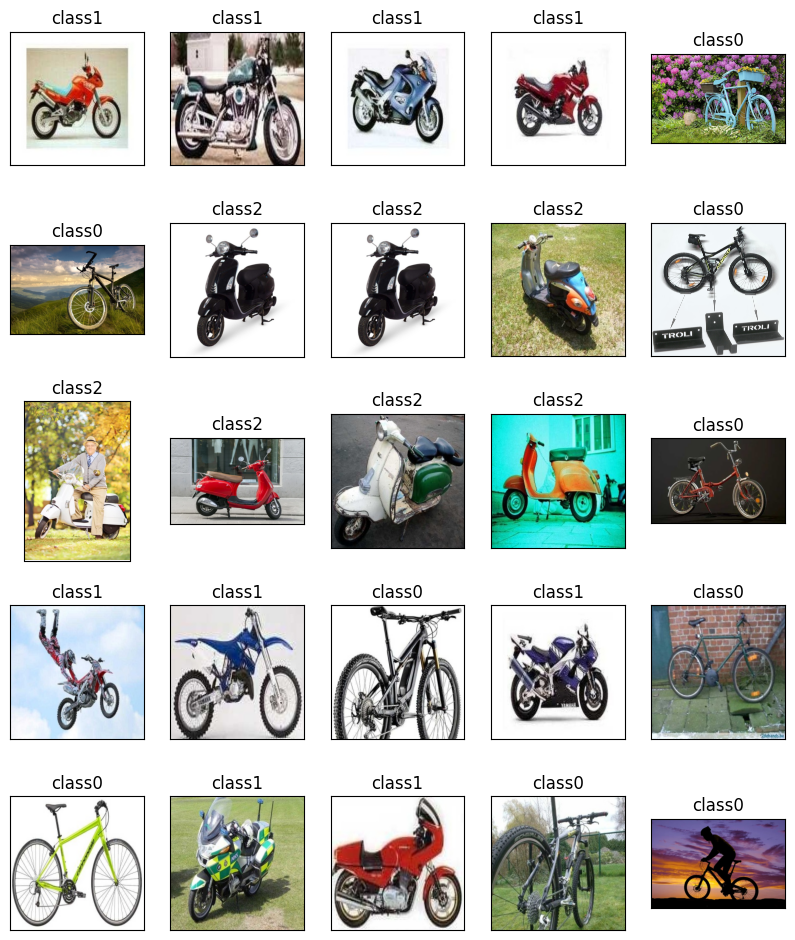

In [4]:
fig = plt.figure(figsize=(10, 12))
visualize_dataset = torchvision.datasets.ImageFolder(root='./Data3/train')
rows, columns = 5, 5
rand_indeces = np.random.randint(low=0, high=len(visualize_dataset), size=(rows*columns,))

images = []
labels = []

for i in rand_indeces:
    img, class_ = visualize_dataset[i]
    images.append(img)
    labels.append(visualize_dataset.classes[class_])

# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{labels[i-1]}")

4. Preparation NN using VGG16 image classificatior model and adding one more linear layer.

In [5]:
from torchvision.models import VGG16_BN_Weights

# Number of classes in the dataset
num_classes = len(train_dataset.classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 256

# Number of epochs to train for 
num_epochs = 15

# Device for running training
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model = models.resnet18(pretrained=True)
model = models.vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1)



# Training only the last layer, the other layers are frozen
for param in model.parameters():
    param.requires_grad = False


num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

print(f"{num_ftrs = }")

num_ftrs = 4096


5. Function for train model.

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()

    train_acc_history = []
    train_loss_history = []

    val_acc_history = []
    val_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    y_pred_proba = torch.softmax(outputs, dim=1)
                    y_pred = y_pred_proba.argmax(dim=1)
                    # print(f"{y_pred = }")
                    # print(f"{labels = }")
                    # print(f"{y_pred.shape = }")
                    # print(f"{labels.shape = }")
                    # loss = criterion(y_pred_proba, labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # print(f"{preds = }")
                # print(f"{labels.data = }")
                running_corrects += torch.sum(y_pred == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

6. Dataloader dict creation.

In [7]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Create training and validation dataloaders
dataloaders_dict = {
    "train": train_dataloader,
    "val": test_dataloader,
}

7. For experiment I'll use Adam optimizer.

In [8]:
# Send the model to GPU
model = model.to(device)

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adam(params=model.parameters())

8. For criterion settings I'll use CrossEntropyLoss.

In [9]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.5785 Acc: 0.7933


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.1598 Acc: 0.9450

Epoch 1/14
----------
train Loss: 0.1465 Acc: 0.9589


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.1180 Acc: 0.9567

Epoch 2/14
----------
train Loss: 0.1117 Acc: 0.9617


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.1100 Acc: 0.9567

Epoch 3/14
----------
train Loss: 0.0968 Acc: 0.9694


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.1021 Acc: 0.9617

Epoch 4/14
----------
train Loss: 0.0815 Acc: 0.9744


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0968 Acc: 0.9650

Epoch 5/14
----------
train Loss: 0.0753 Acc: 0.9739


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0904 Acc: 0.9650

Epoch 6/14
----------
train Loss: 0.0839 Acc: 0.9772


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.1087 Acc: 0.9533

Epoch 7/14
----------
train Loss: 0.0993 Acc: 0.9678


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0926 Acc: 0.9633

Epoch 8/14
----------
train Loss: 0.0895 Acc: 0.9672


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0954 Acc: 0.9617

Epoch 9/14
----------
train Loss: 0.0792 Acc: 0.9728


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0957 Acc: 0.9617

Epoch 10/14
----------
train Loss: 0.0735 Acc: 0.9750


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.1039 Acc: 0.9583

Epoch 11/14
----------
train Loss: 0.0673 Acc: 0.9783


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0909 Acc: 0.9633

Epoch 12/14
----------
train Loss: 0.0683 Acc: 0.9789


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0799 Acc: 0.9700

Epoch 13/14
----------
train Loss: 0.0603 Acc: 0.9822


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0986 Acc: 0.9583

Epoch 14/14
----------
train Loss: 0.0628 Acc: 0.9811


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0828 Acc: 0.9683

Training complete in 118m 32s
Best val Acc: 0.970000


9. Save model params.

In [10]:
torch.save(model.state_dict(), 'course_project_weights_with_vgg_16.pth')

In [11]:
val_acc_history_cpu = [i.item() for i in val_acc_history]
val_loss_history_cpu = val_loss_history
train_acc_history_cpu = [i.item() for i in train_acc_history]
train_loss_history_cpu = train_loss_history

10. Building accuracy plot.

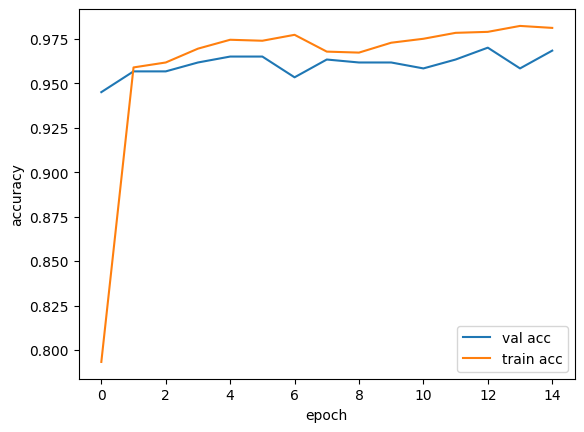

In [12]:
plt.plot(val_acc_history_cpu, label="val acc")
plt.plot(train_acc_history_cpu, label="train acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

11. Building train/test loss curve.

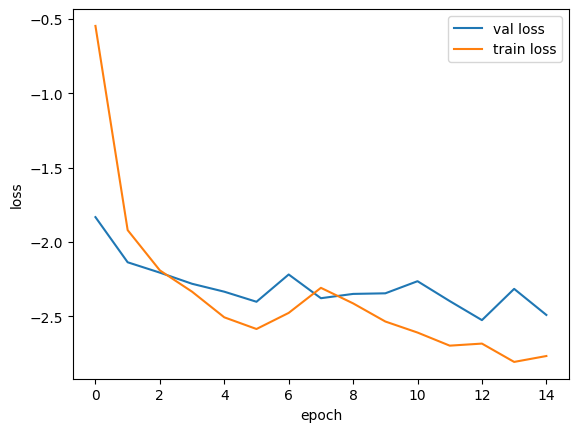

In [13]:
plt.plot(np.log(np.array(val_loss_history_cpu)), label="val loss")
plt.plot(np.log(np.array(train_loss_history_cpu)), label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

12. Conclusions

    I think it's a good result using VGG model with 16 weights for my dataset with next hyperparams: model - VGG with 16 weights; epoches - 15;
batch size - 256; Optimizer - Adam; Creterion - CrossEntropyLoss. It's gives me 97% best accuracy and took 118 minutes to traine. File of model's params - "course_project_weights_with_vgg_16.pth".

                                                Part 2.

                                                Experiment 1.

2.1. Write me own NN.

In [14]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

2.2. Dataset preparation.

In [22]:
train_transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [23]:
train_dataset1 = torchvision.datasets.ImageFolder(
    root='./Data3/train',
    transform=train_transform1)
test_dataset1 = torchvision.datasets.ImageFolder(
    root='./Data3/test',
    transform=test_transform1)

2.3. Set hyperparams with SGD optimizer.

In [26]:
# Number of classes in the dataset
num_classes1 = len(train_dataset.classes)

# Batch size for training (change depending on how much memory you have)
batch_size1 = 64

# Number of epochs to train for 
num_epochs1 = 15

model1 = Net()
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model = models.resnet18(pretrained=True)

train_dataloader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=batch_size1, shuffle=True, num_workers=4)
test_dataloader1 = torch.utils.data.DataLoader(test_dataset1, batch_size=batch_size1, shuffle=False, num_workers=4)

# Create training and validation dataloaders
dataloaders_dict1 = {
    "train": train_dataloader1,
    "val": test_dataloader1,
}

model1 = model1.to(device)

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_ft1 = optim.SGD(params=model1.parameters(), lr=0.001, momentum=0.9)


2.4. Use CrossEntropyLoss. Train model.

In [27]:
# Setup the loss fxn
criterion1 = nn.CrossEntropyLoss()

# Train and evaluate
model_ft1, val_acc_history1, val_loss_history1, train_acc_history1, train_loss_history1 = train_model(model1, dataloaders_dict1, criterion1, optimizer_ft1, num_epochs=num_epochs1)

Epoch 0/14
----------
train Loss: 2.1537 Acc: 0.2883


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 1.7687 Acc: 0.4700

Epoch 1/14
----------
train Loss: 1.2590 Acc: 0.3733


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 1.1397 Acc: 0.3417

Epoch 2/14
----------
train Loss: 1.1128 Acc: 0.3772


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 1.0779 Acc: 0.4433

Epoch 3/14
----------
train Loss: 1.0523 Acc: 0.4450


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 1.0110 Acc: 0.5083

Epoch 4/14
----------
train Loss: 1.0223 Acc: 0.4644


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.9013 Acc: 0.6300

Epoch 5/14
----------
train Loss: 0.9481 Acc: 0.5189


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.8603 Acc: 0.5533

Epoch 6/14
----------
train Loss: 0.9187 Acc: 0.5217


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.8425 Acc: 0.6200

Epoch 7/14
----------
train Loss: 0.8991 Acc: 0.5633


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.8098 Acc: 0.6500

Epoch 8/14
----------
train Loss: 0.8789 Acc: 0.5750


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.8004 Acc: 0.6650

Epoch 9/14
----------
train Loss: 0.8499 Acc: 0.5917


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.7614 Acc: 0.6667

Epoch 10/14
----------
train Loss: 0.8181 Acc: 0.6167


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.7389 Acc: 0.6583

Epoch 11/14
----------
train Loss: 0.8131 Acc: 0.6283


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.7398 Acc: 0.6717

Epoch 12/14
----------
train Loss: 0.7784 Acc: 0.6450


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.7183 Acc: 0.7050

Epoch 13/14
----------
train Loss: 0.7567 Acc: 0.6511


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.7026 Acc: 0.6900

Epoch 14/14
----------
train Loss: 0.7582 Acc: 0.6589


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.6958 Acc: 0.6750

Training complete in 41m 44s
Best val Acc: 0.705000


2.5. Save weights of the model.

In [30]:
torch.save(model1.state_dict(), 'course_project_var1.pth')

In [31]:
val_acc_history_cpu1 = [i.item() for i in val_acc_history1]
val_loss_history_cpu1 = val_loss_history1
train_acc_history_cpu1 = [i.item() for i in train_acc_history1]
train_loss_history_cpu1 = train_loss_history1

2.6. Build accuracy plot.

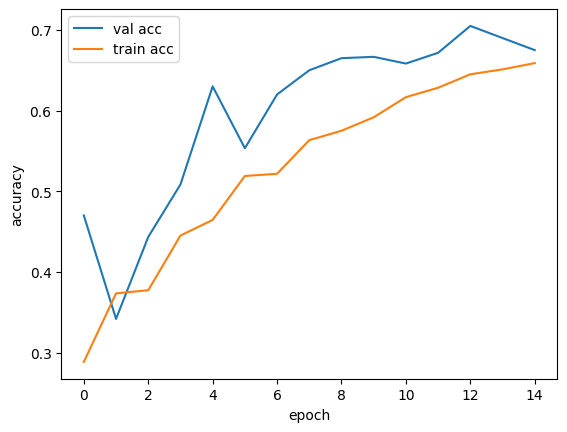

In [32]:
plt.plot(val_acc_history_cpu1, label="val acc")
plt.plot(train_acc_history_cpu1, label="train acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

2.6. Build train/test loss plot curve.

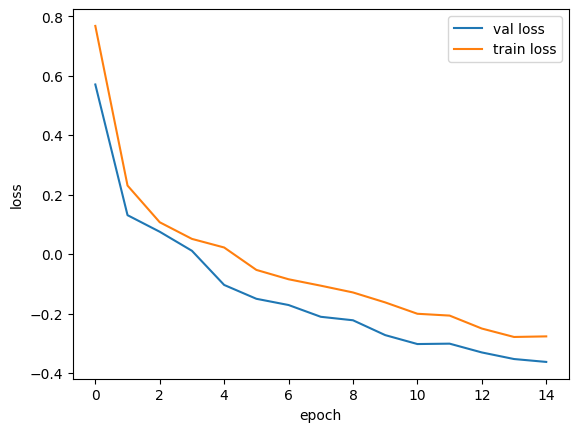

In [33]:
plt.plot(np.log(np.array(val_loss_history_cpu1)), label="val loss")
plt.plot(np.log(np.array(train_loss_history_cpu1)), label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

2.7. Conclusions for experiment 1.

I think it's not bad result. Using next hyperparams I got 70% best accuracy: batch size 64; epoches - 15; optimizer - SGD with momentum - 0.9;
criterion - CrossEntropyLoss. File of model's params - "course_project_var1.pth".


                                            Experiment 2.

3.1. Update NN by adding conv2d and one more Linear layer.

In [2]:
class Net1(nn.Module):
    def __init__(self, num_classes=3):
        super(Net1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

3.2. Dataset preparation.

In [34]:
train_transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [35]:
train_dataset2 = torchvision.datasets.ImageFolder(
    root='./Data4/train',
    transform=train_transform2)
test_dataset2 = torchvision.datasets.ImageFolder(
    root='./Data4/test',
    transform=test_transform2)

2.3. Set hyperparams with Adam optimizer.

In [36]:
# Number of classes in the dataset
num_classes2 = len(train_dataset2.classes)

# Batch size for training (change depending on how much memory you have)
batch_size2 = 128

# Number of epochs to train for 
num_epochs2 = 20

model2 = Net1(num_classes=num_classes2)
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model = models.resnet18(pretrained=True)

train_dataloader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size2, shuffle=True, num_workers=4)
test_dataloader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=batch_size2, shuffle=False, num_workers=4)

# Create training and validation dataloaders
dataloaders_dict2 = {
    "train": train_dataloader2,
    "val": test_dataloader2,
}

model2 = model2.to(device)

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_ft2 = optim.Adam(params=model2.parameters(), lr=0.0001)


2.4. Use CrossEntropyLoss. Train model.

In [37]:
# Setup the loss fxn
criterion2 = nn.CrossEntropyLoss()

# Train and evaluate
model_ft2, val_acc_history2, val_loss_history2, train_acc_history2, train_loss_history2 = train_model(model2, dataloaders_dict2, criterion2, optimizer_ft2, num_epochs=num_epochs2)

Epoch 0/19
----------
train Loss: 1.0878 Acc: 0.3856
val Loss: 1.0275 Acc: 0.5617

Epoch 1/19
----------
train Loss: 0.9467 Acc: 0.5533
val Loss: 1.1120 Acc: 0.4850

Epoch 2/19
----------
train Loss: 0.9552 Acc: 0.5311
val Loss: 0.8249 Acc: 0.6633

Epoch 3/19
----------
train Loss: 0.8224 Acc: 0.6083
val Loss: 0.7256 Acc: 0.6667

Epoch 4/19
----------
train Loss: 0.7029 Acc: 0.6844
val Loss: 0.7291 Acc: 0.7033

Epoch 5/19
----------
train Loss: 0.6058 Acc: 0.7533
val Loss: 0.4632 Acc: 0.8183

Epoch 6/19
----------
train Loss: 0.5301 Acc: 0.7833
val Loss: 0.4126 Acc: 0.8433

Epoch 7/19
----------
train Loss: 0.4296 Acc: 0.8322
val Loss: 0.4839 Acc: 0.8100

Epoch 8/19
----------
train Loss: 0.4198 Acc: 0.8333
val Loss: 0.4066 Acc: 0.8400

Epoch 9/19
----------
train Loss: 0.3648 Acc: 0.8606
val Loss: 0.3212 Acc: 0.8850

Epoch 10/19
----------
train Loss: 0.3319 Acc: 0.8722
val Loss: 0.3536 Acc: 0.8667

Epoch 11/19
----------
train Loss: 0.2833 Acc: 0.8928
val Loss: 0.5077 Acc: 0.8217

Ep

3.5. Save weights of the model.

In [38]:
torch.save(model2.state_dict(), 'course_project_var2.pth')

In [39]:
val_acc_history_cpu2 = [i.item() for i in val_acc_history2]
val_loss_history_cpu2 = val_loss_history2
train_acc_history_cpu2 = [i.item() for i in train_acc_history2]
train_loss_history_cpu2 = train_loss_history2

3.6. Build accuracy plot.

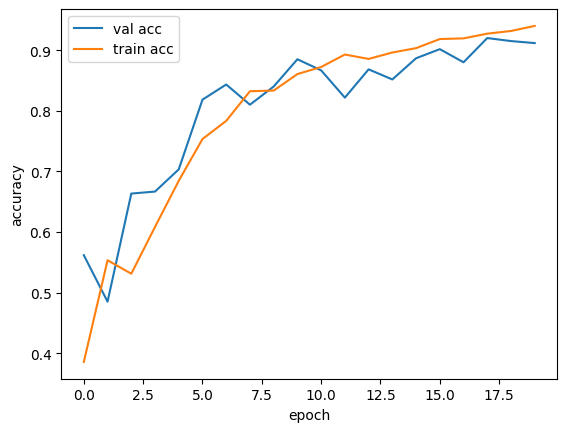

In [40]:
plt.plot(val_acc_history_cpu2, label="val acc")
plt.plot(train_acc_history_cpu2, label="train acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

3.7. Build train/test loss plot curve.

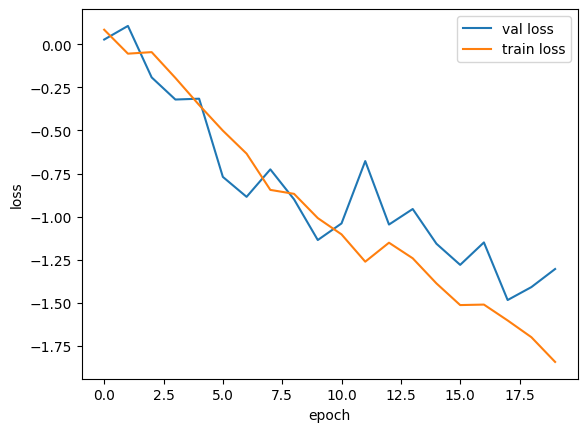

In [41]:
plt.plot(np.log(np.array(val_loss_history_cpu2)), label="val loss")
plt.plot(np.log(np.array(train_loss_history_cpu2)), label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

3.8. Conclusions for experiment 1.

I think it's a very good result. Using next hyperparams I got 92% best accuracy: batch size 128; epoches - 20; optimizer - Adamh with lr - 0.0001;
criterion - CrossEntropyLoss. File of model's params - "course_project_var2.pth".


                                                    Part 3.
                                                    Gradio

4.1. Create interface

In [3]:
import gradio as gr
import torch
from torchvision import transforms
from PIL import Image

# Load the PyTorch model with the .pth weights file
model_dict = torch.load('course_project_var2.pth')
model3 = Net1()
model3.load_state_dict(model_dict)
model3.eval()

# Define the function to predict the class of an image
def predict_class(image):
    # Preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    img_tensor = preprocess(Image.fromarray(image.astype('uint8'), 'RGB'))
    img_tensor.unsqueeze_(0)

    # Make the prediction
    with torch.no_grad():
        output = model3(img_tensor)
        _, predicted = torch.max(output.data, 1)
        class_idx = predicted.item()
        if class_idx == 0:
            return 'bicycle'
        elif class_idx == 1:
            return 'motorcycle'
        else:
            return 'scooter'

# Create the Gradio interface
inputs = gr.inputs.Image()
outputs = gr.outputs.Textbox()
interface = gr.Interface(fn=predict_class, inputs=inputs, outputs=outputs, title='PyTorch Model Prediction', 
                         description='Predicts the class of an input image using a PyTorch model with .pth weights.')
interface.launch(share=True)


/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/aleksejprodius/PycharmProjects/Nero_homeworks/Homework11 - Prodyus Oleksii/venv/lib/python3.10/site-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://ef7c3c0ecbb3d8a61a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
